In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import sys
import os

# Add the src directory to the Python path
src_path = os.path.join(os.getcwd(), 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

In [12]:
import ast
import csv
import itertools
import random
from itertools import product

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from loss_functions import *
from src.activation_functions import *
from src.batch_normalization import *
from src.data_preprocessing import *
from src.ensemble.cascade_correlation import CascadeCorrelation
from src.k_fold_cross_validation import *
from src.layer import *
from src.model_regularization import *
from src.neural_network import *
from src.optimizers import *
from src.random_search import *
from src.train_and_evaluate import *
from src.utils import *

# from src.random_search import *

np.random.seed(0)

<!-- #### Data pre-processing for MONK Datasets  -->

In [13]:
X_train, y_train = load_data(MONK_NUM=1)
X_test, y_test = load_data(MONK_NUM=1, train=False)

one hot encoded data:  (124, 17)
one hot encoded data:  (432, 17)


In [14]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_val = np.asarray(X_val)
y_val = np.asarray(y_val)

In [15]:
print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Training set overlap with validation set:",
      np.intersect1d(X_train, X_val).shape[0])

Training set size: 99
Validation set size: 25
Training set overlap with validation set: 2


In [16]:
# Print the shape of the resulting datasets
for _ in [X_train, X_val, y_train, y_val]:
    print(f"the shape: ", _.shape)

the shape:  (99, 17)
the shape:  (25, 17)
the shape:  (99,)
the shape:  (25,)


In [42]:
param_distributions = {
    'hidden_size': [[3], [4], [5], [6]],
    'hidden_activation': [[Activation_Tanh], [Activation_Leaky_ReLU], [Activation_Sigmoid], [Activation_ReLU]],
    'batch_norm': [[True], [False]],
    'learning_rate': [1e-4, 1e-3, 1e-2, 1e-1],
    'l1': [1e-5, 1e-4, 1e-3, 1e-2],
    'l2': [1e-5, 1e-4, 1e-3, 1e-2],
    'dropout_rate': [0.0, 0.1, 0.3],
    'batch_size': [8, 16, 32],
    'n_epochs': [150, 200],
    'weight_decay': list(np.arange(0.0, 0.05, 0.01))
    # # Define combinations of hidden layer sizes and corresponding activations
    # 'hidden_configs': [
    #     {'hidden_size': [10], 'hidden_activation': [Activation_Tanh], 'batch_norm' : [True]},
    #     {'hidden_size': [10, 10], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm' : [True, True]},
    #     {'hidden_size': [10, 10], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm' : [True, True]},
    #     {'hidden_size': [20, 20], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm' : [True, False]},
    #     {'hidden_size': [20, 20], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm' : [True, True]},
    #     {'hidden_size': [20, 20], 'hidden_activation': [Activation_ELU, Activation_ELU], 'batch_norm' : [True, False]},
    #     {'hidden_size': [10, 10], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm' : [True, False]},
    #     {'hidden_size': [32, 16], 'hidden_activation': [Activation_Leaky_ReLU, Activation_Sigmoid], 'batch_norm' : [False, True]},  
    #     {'hidden_size': [30, 30], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm' : [True, False]},
    #     {'hidden_size': [64, 32, 16], 'hidden_activation': [Activation_ReLU, Activation_ReLU, Activation_Tanh], 'batch_norm' : [True, False, True]},
    #     {'hidden_size': [30, 30], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm': [True, False]}
    # ]   
}

TODO:

Create a seperate best_results csv file for each MONK 

In [ ]:
best_hyperparams, best_performance = random_search(X_train=X_train,
                                                   y_train=y_train,
                                                   param_distributions=param_distributions,
                                                   n_iters=5)  # adjust n_iters as needed

print(best_hyperparams)

[3] [<class 'src.activation_functions.Activation_Leaky_ReLU'>] [0.0] [False]
✅ Fold 1/5 | Validation Accuracy: 0.7500
[3] [<class 'src.activation_functions.Activation_Leaky_ReLU'>] [0.0] [False]
✅ Fold 2/5 | Validation Accuracy: 0.3500
[3] [<class 'src.activation_functions.Activation_Leaky_ReLU'>] [0.0] [False]
✅ Fold 3/5 | Validation Accuracy: 0.6500
[3] [<class 'src.activation_functions.Activation_Leaky_ReLU'>] [0.0] [False]
✅ Fold 4/5 | Validation Accuracy: 0.6000
[3] [<class 'src.activation_functions.Activation_Leaky_ReLU'>] [0.0] [False]
✅ Fold 5/5 | Validation Accuracy: 0.4737

📊 Manual K-Fold | Mean Validation Accuracy over 5 folds: 0.5647
[3] [<class 'src.activation_functions.Activation_Leaky_ReLU'>] [0.0] [False]
✅ Fold 1/5 | Validation Accuracy: 0.7500
[3] [<class 'src.activation_functions.Activation_Leaky_ReLU'>] [0.0] [False]
✅ Fold 2/5 | Validation Accuracy: 0.3000
[3] [<class 'src.activation_functions.Activation_Leaky_ReLU'>] [0.0] [False]
✅ Fold 3/5 | Validation Accuracy

In [44]:
learning_rate, l1, l2, dropout_rate, batch_size, n_epochs, hidden_size, hidden_activation, use_batch_norm, weight_decay, validation_accuracy = best_hyperparams.values()
learning_rate, l1, l2, dropout_rate, batch_size, n_epochs, hidden_size, hidden_activation, use_batch_norm, weight_decay

(0.01,
 0.001,
 1e-05,
 0.3,
 32,
 150,
 [6],
 ['Activation_Leaky_ReLU'],
 [True],
 np.float64(0.0))

GRID SEARCH

In [45]:
activation_map = {
    'Activation_ReLU': Activation_ReLU,
    'Activation_Tanh': Activation_Tanh,
    'Activation_ELU': Activation_ELU,
    'Activation_Leaky_ReLU': Activation_Leaky_ReLU,
    'Activation_Sigmoid': Activation_Sigmoid
}

hidden_activation = [activation_map[act] for act in hidden_activation]  

In [46]:

# model = NN(
#     l1=l1,
#     l2=l2,
#     input_size=17,
#     hidden_sizes=hidden_size,
#     output_size=1,
#     hidden_activations=hidden_activation,
#     dropout_rates=[dropout_rate],
#     use_batch_norm=use_batch_norm
# )
model = CascadeCorrelation(input_size = 17, output_size= 1, activation=Activation_Leaky_ReLU, output_activation = Activation_Sigmoid)
batch_size = batch_size
learning_rate = learning_rate
n_epochs = n_epochs

Data shapes:
X_train: (99, 17), y_train: (99,)
Epoch 0: Train Loss: 0.1059, Acc: 89.06% | Val Loss: 0.3234, Acc: 80.00%
Epoch 10: Train Loss: 0.1102, Acc: 89.06% | Val Loss: 0.3242, Acc: 80.00%
Epoch 20: Train Loss: 0.1142, Acc: 88.28% | Val Loss: 0.3254, Acc: 84.00%
Epoch 30: Train Loss: 0.1142, Acc: 88.28% | Val Loss: 0.3265, Acc: 84.00%
Epoch 40: Train Loss: 0.1038, Acc: 89.84% | Val Loss: 0.3287, Acc: 80.00%
Epoch 50: Train Loss: 0.1045, Acc: 89.06% | Val Loss: 0.3305, Acc: 84.00%
Epoch 60: Train Loss: 0.1237, Acc: 88.28% | Val Loss: 0.3327, Acc: 84.00%
Epoch 70: Train Loss: 0.1198, Acc: 88.28% | Val Loss: 0.3342, Acc: 84.00%
Epoch 80: Train Loss: 0.1044, Acc: 89.06% | Val Loss: 0.3359, Acc: 84.00%
Epoch 90: Train Loss: 0.1159, Acc: 89.06% | Val Loss: 0.3374, Acc: 84.00%
Epoch 100: Train Loss: 0.1351, Acc: 82.29% | Val Loss: 0.3408, Acc: 80.00%
Early stopping at epoch 100
Restoring model weights from epoch 0
Final Validation Accuracy: 0.8000
Test Accuracy: 0.7477


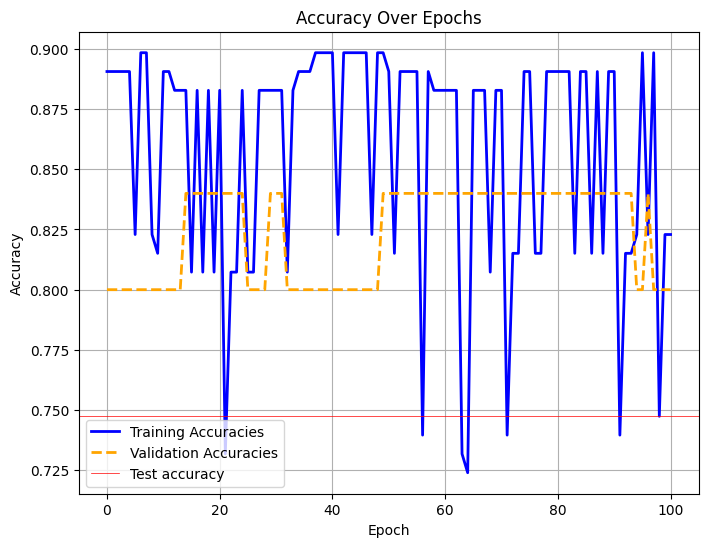

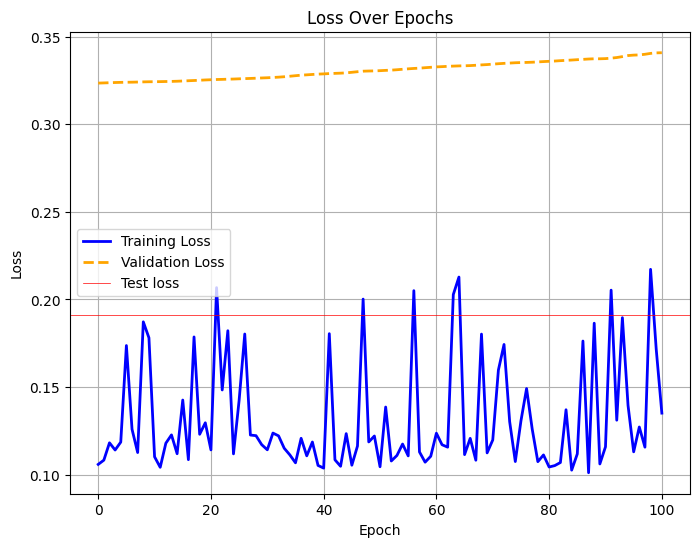

In [55]:
import copy

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

loss_function = MSE()
optimizer = Optimizer_Adam(learning_rate=learning_rate, decay=1e-3)

# Initialize early stopping
early_stopping = EarlyStopping(patience=100, min_delta_loss=1e-5, min_delta_accuracy=0.001)

# Before training loop:
print("Data shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
# print(f"Sample prediction: {model.forward(X_train[:1])}")
# print(f"Initial loss: {loss_function.forward(model.output, y_train[:1])}")

# Training loop
for epoch in range(n_epochs):
    batch_losses = []
    batch_accuracies = []

    for X_batch, y_batch in create_batches(X_train, y_train, batch_size):
        # Forward pass
        model.forward(X_batch, training=True)

        # Loss and accuracy
        loss = loss_function.forward(model.output, y_batch)
        predictions = np.round(model.output.squeeze())
        accuracy = np.mean(predictions == y_batch.squeeze())

        # Backward pass
        loss_function.backward(model.output, y_batch)
        dvalues = loss_function.dinputs

        assert dvalues.shape == model.output.shape, \
            f"Gradient shape mismatch: {dvalues.shape} vs {model.output.shape}"

        for layer in reversed(model.layers):
            layer.backward(dvalues)
            dvalues = layer.dinputs

            # Regularization
            if isinstance(layer, Layer_Dense):
                if layer.l1 > 0:
                    layer.dweights += layer.l1 * np.sign(layer.weights)
                if layer.l2 > 0:
                    layer.dweights += 2 * layer.l2 * layer.weights

        # Update weights
        optimizer.pre_update_params()
        for layer in model.layers:
            if isinstance(layer, Layer_Dense):
                optimizer.update_params(layer)
        optimizer.post_update_params()

        batch_losses.append(loss)
        batch_accuracies.append(accuracy)

    # Epoch summary
    epoch_loss = np.mean(batch_losses)
    epoch_acc = np.mean(batch_accuracies)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation
    X_val_input = X_val.values if isinstance(X_val, pd.DataFrame) else X_val
    y_val_input = y_val.values if isinstance(y_val, (pd.Series, pd.DataFrame)) else y_val

    model.forward(X_val_input, training=False)
    val_loss = loss_function.forward(model.output, y_val_input)
    val_predictions = np.round(model.output.squeeze())
    val_accuracy = np.mean(val_predictions == y_val.squeeze())

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Cascade correlation
    if isinstance(model, CascadeCorrelation):
        if model.is_limit_reached():
            break
        if len(val_losses) > 2 and val_losses[-1] > val_losses[-2]: # model is getting worse
            early_stopping.restore_weights(model.layers)
            model.add_neuron()
            print(f"Added new neuron at val_loss {val_losses[-1]}")

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: ", end="")
        print(f"Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc*100:.2f}% | ", end="")
        print(f"Val Loss: {val_loss:.4f}, Acc: {val_accuracy*100:.2f}%")

    # Early stopping check
    early_stopping.on_epoch_end(
        current_loss=val_loss,
        current_accuracy=val_accuracy,
        model=model.layers,
        epoch=epoch
    )

    if early_stopping.stop_training:
        print(f"Early stopping at epoch {epoch}")
        # Restore best weights
        print(f"Restoring model weights from epoch {early_stopping.best_epoch}")
        early_stopping.restore_weights(model)
        break

# Final evaluation
model.forward(X_val_input, training=False)
final_val_loss = loss_function.forward(model.output, y_val_input)
final_val_accuracy = np.mean(np.round(model.output.squeeze()) == y_val.squeeze())
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")


# Test set evaluation
model.forward(X_test, training=False)
test_loss = loss_function.forward(model.output.squeeze(), y_test)

predictions = np.round(model.output.squeeze())
y_true = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test
test_accuracy = np.mean(predictions == y_true)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot training progress
plot_accuracies(train_accuracies, val_accuracies, test_accuracy,
                label1="Training Accuracies", label2="Validation Accuracies",
                title="Accuracy Over Epochs")

plot_losses(train_losses, val_losses, test_loss,
            label1="Training Loss", label2="Validation Loss",
            title="Loss Over Epochs")

In [56]:
print(train_losses, val_losses)

[np.float64(0.10589569006700467), np.float64(0.10831733172979986), np.float64(0.11820346834483228), np.float64(0.11409944782792186), np.float64(0.11861843465540978), np.float64(0.1737027115929357), np.float64(0.12594394487525923), np.float64(0.11265506465601005), np.float64(0.18723064334021464), np.float64(0.1781093889937153), np.float64(0.1102271048583517), np.float64(0.10422843254457007), np.float64(0.11798694702108417), np.float64(0.12272366470500319), np.float64(0.11197925036668788), np.float64(0.14260998195224697), np.float64(0.10859139097092131), np.float64(0.17861211485183331), np.float64(0.12307620952490472), np.float64(0.12962630961438373), np.float64(0.1141599426208759), np.float64(0.2067476752835393), np.float64(0.14835477939906788), np.float64(0.18215309084335718), np.float64(0.11189259215824063), np.float64(0.14241877587081275), np.float64(0.18028102339269858), np.float64(0.12264099160838679), np.float64(0.12228381539298816), np.float64(0.11716890726930307), np.float64(0.1

In [57]:
model.forward(X_test, training=False)
# Compute softmax probabilities for the test output
# print(X_test.shape, y_test.shape)
# print(model.output, y_test)
loss_function.forward(model.output.squeeze(), y_test)
# Calculate accuracy for the test set
predictions = np.round(model.output.squeeze())
if len(y_test.shape) == 2:
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test

# Compute test accuracy
test_accuracy = np.mean(predictions == y_true)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.7477
